In [4]:
import numpy as np
import xlrd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files 
uploaded = files.upload()


Saving entrada.xlsx to entrada.xlsx


In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving entrada_2.xlsx to entrada_2 (1).xlsx


A funcao 'plota' produz um gráfico da estrutura definida pela matriz de nos N 
e pela incidencia Inc.

Sugestao de uso:

from funcoesTermosol import plota
plota(N,Inc)
-------------------------------------------------------------------------------
A funcao 'importa' retorna o numero de nos [nn], a matriz dos nos [N], o numero
de membros [nm], a matriz de incidencia [Inc], o numero de cargas [nc], o vetor
carregamento [F], o numero de restricoes [nr] e o vetor de restricoes [R] 
contidos no arquivo de entrada.

Sugestao de uso:
    
from funcoesTermosol import importa
[nn,N,nm,Inc,nc,F,nr,R] = importa('entrada.xlsx')
-------------------------------------------------------------------------------
A funcao 'geraSaida' cria um arquivo nome.txt contendo as reacoes de apoio Ft, 
deslocamentos Ut, deformacoes Epsi, forcas Fi e tensoes Ti internas. 
As entradas devem ser vetores coluna.

Sugestao de uso:
    
from funcoesTermosol import geraSaida
geraSaida(nome,Ft,Ut,Epsi,Fi,Ti)
-------------------------------------------------------------------------------



In [5]:
def plota(N,Inc):
    # Numero de membros
    nm = len(Inc[:,0])
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt

#    plt.show()
    fig = plt.figure()
    # Passa por todos os membros
    for i in range(nm):
        
        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc[i,0])
        n2 = int(Inc[i,1])        

        plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color='r',linewidth=3)

    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [6]:
def importa(entradaNome):

    
    arquivo = xlrd.open_workbook(entradaNome)
    
    ################################################## Ler os nos
    nos = arquivo.sheet_by_name('Nos')
    
    # Numero de nos
    nn = int(nos.cell(1,3).value)
                 
    # Matriz dos nós
    N = np.zeros((2,nn))
    
    for c in range(nn):
        N[0,c] = nos.cell(c+1,0).value
        N[1,c] = nos.cell(c+1,1).value
    
    ################################################## Ler a incidencia
    incid = arquivo.sheet_by_name('Incidencia')
    
    # Numero de membros
    nm = int(incid.cell(1,5).value)
                 
    # Matriz de incidencia
    Inc = np.zeros((nm,4))
    
    for c in range(nm):
        Inc[c,0] = int(incid.cell(c+1,0).value)
        Inc[c,1] = int(incid.cell(c+1,1).value)
        Inc[c,2] = incid.cell(c+1,2).value
        Inc[c,3] = incid.cell(c+1,3).value
    
    ################################################## Ler as cargas
    carg = arquivo.sheet_by_name('Carregamento')
    
    # Numero de cargas
    nc = int(carg.cell(1,4).value)
                 
    # Vetor carregamento
    F = np.zeros((nn*2,1))
    
    for c in range(nc):
        no = carg.cell(c+1,0).value
        xouy = carg.cell(c+1,1).value
        GDL = int(no*2-(2-xouy)) 
        F[GDL-1,0] = carg.cell(c+1,2).value
         
    ################################################## Ler restricoes
    restr = arquivo.sheet_by_name('Restricao')
    
    # Numero de restricoes
    nr = int(restr.cell(1,3).value)
                 
    # Vetor com os graus de liberdade restritos
    R = np.zeros((nr,1))
    
    for c in range(nr):
        no = restr.cell(c+1,0).value
        xouy = restr.cell(c+1,1).value
        GDL = no*2-(2-xouy) 
        R[c,0] = GDL-1


    return nn,N,nm,Inc,nc,F,nr,R


In [7]:
def geraSaida(nome,Ft,Ut,Epsi,Fi,Ti):
    nome = nome + '.txt'
    f = open("saida.txt","w+")
    f.write('Reacoes de apoio [N]\n')
    f.write(str(Ft))
    print(str(Ft))
    f.write('\n\nDeslocamentos [m]\n')
    f.write(str(Ut))
    print(str(Ut))
    f.write('\n\nDeformacoes []\n')
    f.write(str(Epsi))
    print(str(Epsi))
    f.write('\n\nForcas internas [N]\n')
    f.write(str(Fi))
    print(str(Fi))
    f.write('\n\nTensoes internas [Pa]\n')
    f.write(str(Ti))
    print(str(Ti))
    f.close()

In [8]:
def get_angles_lenghts(N,Inc,nm):
  angs = np.zeros((nm,nm))
  Ls = []
  for i in range(nm):
    nos = int(Inc[i,0])-1,int(Inc[i,1])-1
    L = np.sqrt((N[nos[1],0]-N[nos[0],0])**2 +(N[nos[1],1]-N[nos[0],1])**2)
    Ls.append(L)
    angs[i,0] = (N[nos[1],0]-N[nos[0],0])/L
    angs[i,1] = (N[nos[1],1]-N[nos[0],1])/L
  return Ls,angs

In [9]:
def fill_matrix(E,A,l,c,s):
  return E*A/l * np.array([[c**2,c*s,-c**2,-c*s],
                [c*s,s**2,-c*s,-s**2],
                [-c**2,-c*s,c**2,c*s],
                [-c*s,-s**2,c*s,s**2]])

In [10]:
def get_matriz_elemento(N,L,Inc,ang,nm):
  lista = []
  for i in range(nm):
    lista.append(fill_matrix(Inc[i,2],Inc[i,3],L[i],ang[i,0], ang[i,1]))
  return lista

In [11]:
def get_matriz_global(N,Inc,ang,nm):
  lista = get_matriz_elemento(N,Ls,Inc,ang,nm)
  matriz_global = np.zeros((2*len(N[:,0]),2*len(N[:,0])))
  for i in range(nm):
      N1,N2 = int(Inc[i,0]),int(Inc[i,1])
        
      grau1 = 2*N1 - 1
      grau2 = 2*N1 
      grau3 = 2*N2 - 1
      grau4 = 2*N2

      matriz_global[grau1-1:grau2, grau1-1:grau2] += lista[i][0:2, 0:2]
      matriz_global[grau3-1:grau4, grau1-1:grau2] += lista[i][2:4, 0:2]
      matriz_global[grau1-1:grau2, grau3-1:grau4] += lista[i][0:2, 2:4]
      matriz_global[grau3-1:grau4, grau3-1:grau4] += lista[i][2:4, 2:4]
      
  return matriz_global

In [12]:
def jacobi(A,b,erro):
    n = len(b[:,0])
    x = np.zeros((n,1))
    x0 = np.zeros((n,1))
    k = 0
    erroAtual = 1
    while erroAtual > erro:
        for i in range(n):
            soma = 0
            for j in range(n):
                if j != i:
                    soma += A[i,j]*x0[j,0]
            x[i,0] = (b[i,0] - soma)/A[i,i]
        erroAtual = np.max(np.abs(x-x0))
        x0 = np.copy(x) 
        k +=1
    return x,k

def gauss_seidel(A, b, tol):
    n = len(b[:,0])
    x = np.zeros((n,1))
    x0 = np.zeros((n,1))
    count = 0
    while True:
        x_new = np.zeros_like(x)
        for i in range(A.shape[0]):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i + 1:], x[i + 1:])
            x_new[i] = (b[i] - s1 - s2) / A[i, i]
        if np.allclose(x, x_new, rtol=tol):
            break
        x = x_new
        count += 1
    return x_new,count


In [13]:
def get_deslocamentos_reacoes(N,R,F,G):
  #Graus de liberdade
  grau_restrito = list(map(lambda x:int(x[0]),R))
  grau_nao_restrito = [x for x in range(2*len(N[:,0])) if x not in grau_restrito]

  #Matrizes de resolução
  matriz_global_com_restricoes = np.take(np.take(G,grau_nao_restrito,axis=0),grau_nao_restrito,axis=1) 
  forca_com_restricoes = np.take(np.array(F),grau_nao_restrito,axis=0)
  
  #solução para deslocamentos
  U = np.linalg.solve(matriz_global_com_restricoes, forca_com_restricoes)
  U1,count1 = jacobi(matriz_global_com_restricoes, forca_com_restricoes,1e-9)
  U2,count2 = gauss_seidel(matriz_global_com_restricoes, forca_com_restricoes,1e-9)
  if count2 < count1:
    U = U2.copy()
    print("usando gauss-seidel")
  else:
    U = U1.copy()
    print("usando Jacobi")
  deslocamentos = np.zeros([len(F),1])

  #Calcuando reacções
  j=0
  for i in range(len(F)):
    if i in grau_nao_restrito:
      deslocamentos[i,0] = U[j,0]
      j+=1

  L = np.dot(G,deslocamentos)
  reacoes = np.take(L,grau_restrito,axis=0)
  return deslocamentos,reacoes


In [14]:
def get_tensoes_deform_tensoes(N,deslocamentos,angs,Inc,nm,Ls):
  defor = []
  tensoes = []
  forcas = []
  for i in range(nm):
    N1,N2 = int(Inc[i,0])-1,int(Inc[i,1])-1
    N1x,N1y,N2x,N2y = 2*N1,2*N1+1,2*N2,2*N2+1
    m = np.array([-angs[i,0],-angs[i,1],angs[i,0],angs[i,1]]).reshape(4,1)
    g = np.array([deslocamentos[N1x],deslocamentos[N1y],deslocamentos[N2x],deslocamentos[N2y]]).reshape(1,4)
    p = np.dot(g,m)[0]
    tensoes.append(Inc[i,2]*p/Ls[i])
    forcas.append(Inc[i,2]*p*Inc[i,3]/(Ls[i]))
    defor.append(p/Ls[i])
  return defor,forcas,tensoes


In [16]:
nn,N,nm,Inc,nc,F,nr,R = importa('entrada.xls')


N_1 = np.transpose(N)
Ls,angs = get_angles_lenghts(N_1,Inc,nm)
G =get_matriz_global(N_1,Inc,angs,nm)
deslocamentos,reacoes = get_deslocamentos_reacoes(N_1,R,F,G)
defor,forcas,tensoes = get_tensoes_deform_tensoes(N_1,deslocamentos,angs,Inc,nm,Ls)
geraSaida("teste",reacoes,deslocamentos,defor,forcas,tensoes)

usando gauss-seidel
[[  75.        ]
 [-224.80529141]
 [  99.84923205]]
[[ 0.00000000e+00]
 [-9.50945067e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60575208e-06]
 [-4.01537818e-06]]
[array([2.37736267e-06]), array([5.35250694e-06]), array([-2.97619048e-06])]
[array([99.84923205]), array([224.80529141]), array([-125.])]
[array([499246.16026889]), array([1124026.4570419]), array([-625000.])]


/tmp/ipykernel_11609/4143776588.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g:" (-> color='g'). The keyword argument will take precedence.
  plt.plot([N[0,n1-1]+deslocamentos[N1x]*e,N[0,n2-1]+deslocamentos[N2x]*e],[N[1,n1-1]+deslocamentos[N1y]*e,N[1,n2-1]+deslocamentos[N2y]*e],'g:',color='y',linewidth=3)


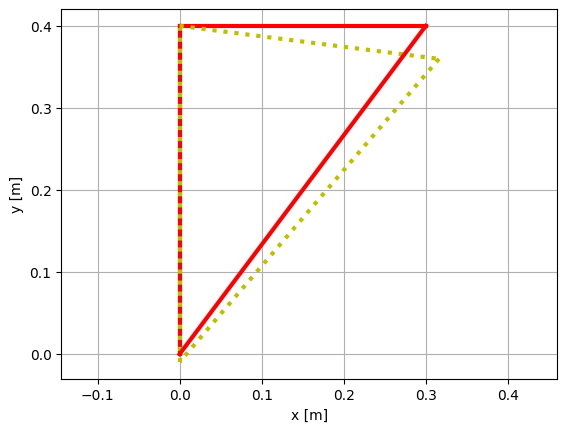

In [17]:
nm = len(Inc[:,0])
import matplotlib as mpl
import matplotlib.pyplot as plt

#    plt.show()
fig = plt.figure()
# Passa por todos os membros
for i in range(nm):
    e = 1e4
    n1 = int(Inc[i,0])
    n2 = int(Inc[i,1])  
    N1 = int(Inc[i,0])-1
    N2 = int(Inc[i,1])-1  
    N1x,N1y,N2x,N2y = 2*N1,2*N1+1,2*N2,2*N2+1      

    plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color='r',linewidth=3)
    plt.plot([N[0,n1-1]+deslocamentos[N1x]*e,N[0,n2-1]+deslocamentos[N2x]*e],[N[1,n1-1]+deslocamentos[N1y]*e,N[1,n2-1]+deslocamentos[N2y]*e],'g:',color='y',linewidth=3)


plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid(True)
plt.axis('equal')
plt.show()

In [19]:
nn,N,nm,Inc,nc,F,nr,R = importa('entrada_2.xls')

N_1 = np.transpose(N)
Ls,angs = get_angles_lenghts(N_1,Inc,nm)
G =get_matriz_global(N_1,Inc,angs,nm)
deslocamentos,reacoes = get_deslocamentos_reacoes(N_1,R,F,G)
defor,forcas,tensoes = get_tensoes_deform_tensoes(N_1,deslocamentos,angs,Inc,nm)
geraSaida("teste",reacoes,deslocamentos,defor,forcas,tensoes)

usando gauss-seidel


/tmp/ipykernel_11609/4339990.py:12: RuntimeWarning: overflow encountered in double_scalars
  soma += A[i,j]*x0[j,0]
/tmp/ipykernel_11609/4339990.py:12: RuntimeWarning: invalid value encountered in double_scalars
  soma += A[i,j]*x0[j,0]


TypeError: get_tensoes_deform_tensoes() missing 1 required positional argument: 'Ls'

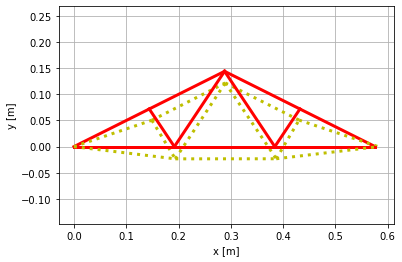

In [152]:
nm = len(Inc[:,0])
import matplotlib as mpl
import matplotlib.pyplot as plt

#    plt.show()
fig = plt.figure()
# Passa por todos os membros
for i in range(nm):
    e = 5
    # encontra no inicial [n1] e final [n2] 
    n1 = int(Inc[i,0])
    n2 = int(Inc[i,1])  
    N1 = int(Inc[i,0])-1
    N2 = int(Inc[i,1])-1  
    N1x,N1y,N2x,N2y = 2*N1,2*N1+1,2*N2,2*N2+1      

    plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color='r',linewidth=3)
    plt.plot([N[0,n1-1]+deslocamentos[N1x]*e,N[0,n2-1]+deslocamentos[N2x]*e],[N[1,n1-1]+deslocamentos[N1y]*e,N[1,n2-1]+deslocamentos[N2y]*e],'g:',color='y',linewidth=3)


plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid(True)
plt.axis('equal')
plt.show()